In [22]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


class SeamCarver:
    def __init__(self, filename, out_height, out_width):
        # initialize parameter
        self.filename = filename
        self.out_height = out_height
        self.out_width = out_width

        # read in image and store as np.float64 format
        self.in_image = cv2.imread(filename).astype(np.float64)
        self.in_height, self.in_width = self.in_image.shape[: 2]

        # keep tracking resulting image
        self.out_image = np.copy(self.in_image)

        # kernel for forward energy map calculation
        self.kernel_x = np.array([[0., 0., 0.], [-1., 0., 1.], [0., 0., 0.]], dtype=np.float64)
        self.kernel_y_left = np.array([[0., 0., 0.], [0., 0., 1.], [0., -1., 0.]], dtype=np.float64)
        self.kernel_y_right = np.array([[0., 0., 0.], [1., 0., 0.], [0., -1., 0.]], dtype=np.float64)

        # constant for covered area by protect mask or object mask
        self.constant = 1000

        # Store seams for visualization
        self.vertical_seams = []
        self.horizontal_seams = []

        # starting program
        self.seams_carving()


    def seams_carving(self):
        """
        :return:

        We first process seam insertion or removal in vertical direction then followed by horizontal direction.

        If targeting height or width is greater than original ones --> seam insertion,
        else --> seam removal

        The algorithm is written for seam processing in vertical direction (column), so image is rotated 90 degree
        counter-clockwise for seam processing in horizontal direction (row)
        """

        # calculate number of rows and columns needed to be inserted or removed
        delta_row, delta_col = int(self.out_height - self.in_height), int(self.out_width - self.in_width)

        # remove column
        if delta_col < 0:
            self.seams_removal(delta_col * -1, vertical=True)

        # remove row
        if delta_row < 0:
            self.out_image = self.rotate_image(self.out_image, 1)
            self.seams_removal(delta_row * -1, vertical=False)
            self.out_image = self.rotate_image(self.out_image, 0)

    def seams_removal(self, num_pixel, vertical=True):
        # Store original dimensions to map seams back to original image space
        original_height, original_width = self.in_image.shape[:2]

        # Keep track of cumulative removed pixels to adjust coordinates
        removed_pixels = np.zeros((original_height if vertical else original_width,), dtype=np.int32)

        for dummy in range(num_pixel):
            energy_map = self.calc_energy_map()
            cumulative_map = self.cumulative_map_forward(energy_map)
            seam_idx = self.find_seam(cumulative_map)

            # Map seam back to original image coordinates before storing
            if vertical:
                # Adjust for already removed columns
                original_seam = np.copy(seam_idx)
                for i in range(len(original_seam)):
                    original_seam[i] += removed_pixels[i]
                self.vertical_seams.append(original_seam)

                # Update removed pixels tracker
                for i in range(len(seam_idx)):
                    removed_pixels[i] += 1
            else:
                # For horizontal, similar approach but track removed rows
                original_seam = np.copy(seam_idx)
                for i in range(len(original_seam)):
                    original_seam[i] += removed_pixels[i]
                self.horizontal_seams.append(original_seam)

                # Update removed pixels tracker
                for i in range(len(seam_idx)):
                    removed_pixels[i] += 1

            self.delete_seam(seam_idx)


    def calc_energy_map(self):
        b, g, r = cv2.split(self.out_image)

        # Compute derivatives manually
        def compute_gradient(channel):
            dx = np.zeros_like(channel)
            dy = np.zeros_like(channel)

            # Compute ∂I/∂x (horizontal gradient)
            dx[:, :-1] = channel[:, 1:] - channel[:, :-1]

            # Compute ∂I/∂y (vertical gradient)
            dy[:-1, :] = channel[1:, :] - channel[:-1, :]

            # Compute energy as |∂I/∂x| + |∂I/∂y|
            return np.abs(dx) + np.abs(dy)

        b_energy = compute_gradient(b)
        g_energy = compute_gradient(g)
        r_energy = compute_gradient(r)

        return b_energy + g_energy + r_energy


    def cumulative_map_forward(self, energy_map):
        matrix_x = self.calc_neighbor_matrix(self.kernel_x)
        matrix_y_left = self.calc_neighbor_matrix(self.kernel_y_left)
        matrix_y_right = self.calc_neighbor_matrix(self.kernel_y_right)

        m, n = energy_map.shape
        output = np.copy(energy_map)
        for row in range(1, m):
            for col in range(n):
                if col == 0:
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_right, e_up)
                elif col == n - 1:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_up)
                else:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_right, e_up)
        return output


    def calc_neighbor_matrix(self, kernel):
        b, g, r = cv2.split(self.out_image)
        output = np.absolute(cv2.filter2D(b, -1, kernel=kernel)) + \
                  np.absolute(cv2.filter2D(g, -1, kernel=kernel)) + \
                  np.absolute(cv2.filter2D(r, -1, kernel=kernel))
        return output


    def find_seam(self, cumulative_map):
        m, n = cumulative_map.shape
        output = np.zeros((m,), dtype=np.uint32)
        output[-1] = np.argmin(cumulative_map[-1])
        for row in range(m - 2, -1, -1):
            prv_x = output[row + 1]
            if prv_x == 0:
                output[row] = np.argmin(cumulative_map[row, : 2])
            else:
                output[row] = np.argmin(cumulative_map[row, prv_x - 1: min(prv_x + 2, n - 1)]) + prv_x - 1
        return output


    def delete_seam(self, seam_idx):
        m, n = self.out_image.shape[: 2]
        output = np.zeros((m, n - 1, 3))
        for row in range(m):
            col = seam_idx[row]
            output[row, :, 0] = np.delete(self.out_image[row, :, 0], [col])
            output[row, :, 1] = np.delete(self.out_image[row, :, 1], [col])
            output[row, :, 2] = np.delete(self.out_image[row, :, 2], [col])
        self.out_image = np.copy(output)


    def update_seams(self, remaining_seams, current_seam):
        output = []
        for seam in remaining_seams:
            seam[np.where(seam >= current_seam)] += 2
            output.append(seam)
        return output


    def rotate_image(self, image, ccw):
        m, n, ch = image.shape
        output = np.zeros((n, m, ch))
        if ccw:
            image_flip = np.fliplr(image)
            for c in range(ch):
                for row in range(m):
                    output[:, row, c] = image_flip[row, :, c]
        else:
            for c in range(ch):
                for row in range(m):
                    output[:, m - 1 - row, c] = image[row, :, c]
        return output


    def save_result(self, filename):
        cv2.imwrite(filename, self.out_image.astype(np.uint8))


    def visualize_seams(self, output_path=None, seam_color=[0, 0, 255], show_vertical=True, show_horizontal=True, max_seams=None):
        """
        Visualizes the seams that were removed during the seam carving process.

        Parameters:
        -----------
        output_path : str
            Path to save the visualization (default=None)
        seam_color : list
            RGB color for seam visualization (default=[0,0,255] for red in BGR)
        show_vertical : bool
            Whether to show vertical seams (default=True)
        show_horizontal : bool
            Whether to show horizontal seams (default=True)
        max_seams : int
            Maximum number of seams to display (default=None, shows all)

        Returns:
        --------
        tuple
            (vertical_visualization, horizontal_visualization) - The images with seams visualized
        """
        # Read the original image for visualization
        orig_image = cv2.imread(self.filename)
        if orig_image is None:
            raise ValueError(f"Could not read image at {self.filename}")

        v_height, v_width = orig_image.shape[:2]

        # Create copies to draw seams on
        vertical_vis = np.copy(orig_image) if show_vertical else None
        horizontal_vis = np.copy(orig_image) if show_horizontal else None

        # Visualize vertical seams
        if show_vertical and self.vertical_seams:
            seams_to_draw = self.vertical_seams[:max_seams] if max_seams else self.vertical_seams
            for seam in seams_to_draw:
                for row in range(len(seam)):
                    col = seam[row]
                    if 0 <= row < v_height and 0 <= col < v_width:
                        vertical_vis[row, col] = seam_color

            # Save visualization if requested
            if output_path:
                cv2.imwrite(f"{output_path}_vertical.jpg", vertical_vis)

        # Visualize horizontal seams
        if show_horizontal and self.horizontal_seams:
            # For horizontal seams, we need to handle the rotation properly
            seams_to_draw = self.horizontal_seams[:max_seams] if max_seams else self.horizontal_seams
            for seam in seams_to_draw:
                for row in range(len(seam)):
                    col = seam[row]
                    # The seam was found on a rotated image, so we need to map it back
                    if 0 <= col < v_height and 0 <= row < v_width:
                        # Map to original image coordinates
                        horizontal_vis[col, v_width - 1 - row] = seam_color

            # Save visualization if requested
            if output_path:
                cv2.imwrite(f"{output_path}_horizontal.jpg", horizontal_vis)

        return vertical_vis, horizontal_vis

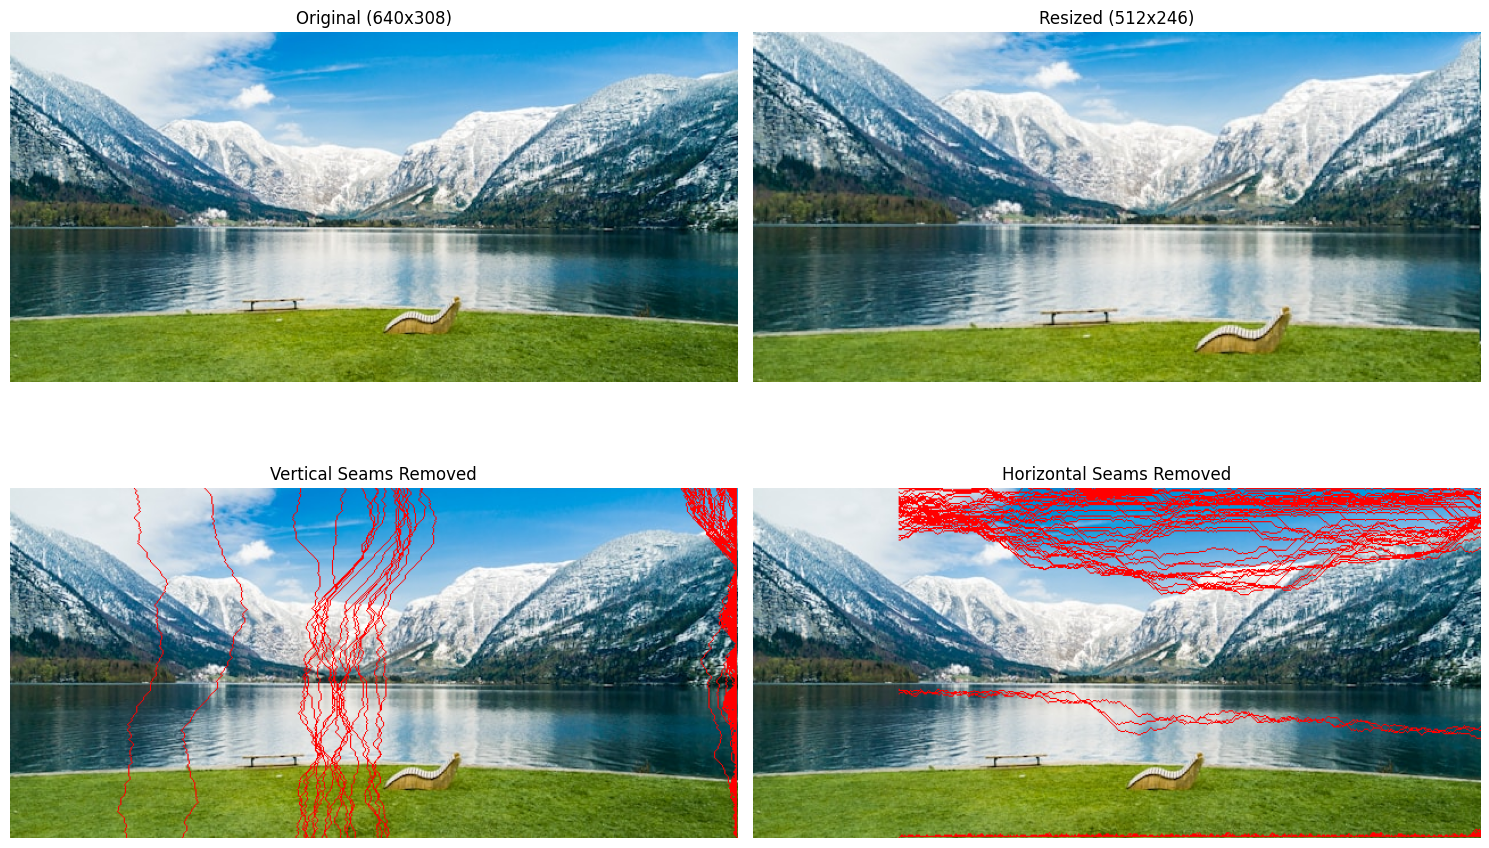

In [23]:
import matplotlib.pyplot as plt


if __name__ == "__main__":
    import os
    import matplotlib.pyplot as plt

    # Change this to your image path
    image_path = "/content/willian-justen-de-vasconcellos-xzJ92bNCXHA-unsplash.jpg"

    # Read the original image
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Could not read image at {image_path}")

    orig_height, orig_width = original.shape[:2]

    # Define target dimensions (e.g., remove 20% of both dimensions)
    target_width = int(orig_width * 0.8)
    target_height = int(orig_height * 0.8)

    # Create a SeamCarver instance
    carver = SeamCarver(image_path,
                        out_height=target_height,
                        out_width=target_width)

    # Save the resized image
    carver.save_result("resized_image.jpg")

    # Visualize the seams that were removed
    vertical_vis, horizontal_vis = carver.visualize_seams(
        output_path="seams_visualization",
        max_seams=None  # Show all seams
    )

    # Plot results with matplotlib for better comparison
    plt.figure(figsize=(15, 10))

    # Original image
    plt.subplot(2, 2, 1)
    rgb_original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_original)
    plt.title(f'Original ({orig_width}x{orig_height})')
    plt.axis('off')

    # Resized image
    plt.subplot(2, 2, 2)
    rgb_resized = cv2.cvtColor(carver.out_image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_resized)
    plt.title(f'Resized ({target_width}x{target_height})')
    plt.axis('off')

    # Vertical seam visualization
    if vertical_vis is not None:
        plt.subplot(2, 2, 3)
        rgb_vertical = cv2.cvtColor(vertical_vis, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_vertical)
        plt.title('Vertical Seams Removed')
        plt.axis('off')

    # Horizontal seam visualization
    if horizontal_vis is not None:
        plt.subplot(2, 2, 4)
        rgb_horizontal = cv2.cvtColor(horizontal_vis, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_horizontal)
        plt.title('Horizontal Seams Removed')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('comparison_visualization.png')
    plt.show()